<a href="https://colab.research.google.com/github/rebulla/iot-mqtt-ml/blob/main/Predict_Traffic_Campo_Grande.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Problem Statement**

According to the typical traffic patterns observed at these points, a timing strategy should be developed based on traffic intensity data collected from the following locations:

**Point 1**: Av. Afonso Pena, 3074-3130 - Centro  
Campo Grande, MS, 79002-072  
Coordinates: -20.462534, -54.607062

**Point 2**: Av. Mal. Deodoro, 1199-1163 - Amambai  
Campo Grande, MS, 79086-101  
Coordinates: -20.496654, -54.650237

### **Imports**

In [ ]:
import gspread
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from google.colab import auth
from google.auth import default

In [ ]:
import sklearn
print(sklearn.__version__)

1.5.2


### **Open & Load (Historical) Data**

In [ ]:
# auth/load google credentials
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Open the Google Sheet by its URL (ensure it's publicly accessible)
sheet_url = 'https://docs.google.com/spreadsheets/d/1k6fSydftRL1L7A1AKBMND-u_uNY83TWlHUMlGI27axI/edit?usp=sharing'

# Authenticate and open the spreadsheet
spreadsheet = gc.open_by_url(sheet_url)

# Select a specific worksheet
worksheet = spreadsheet.worksheet("sample-data-typical-traffic")

# Get all values from the worksheet
values = worksheet.get_all_values()

# Convert to a Pandas DataFrame
df = pd.DataFrame(values[1:], columns=values[0])  # Assuming the first row contains column headers

In [ ]:
df

,time,period,day,position,typical_traffic
0,00:00:00,NIGHT,sunday,"-20.496654, -54.650237",GREEN
1,00:11:00,NIGHT,sunday,"-20.496654, -54.650237",GREEN
2,00:22:00,NIGHT,sunday,"-20.496654, -54.650237",GREEN
3,00:33:00,NIGHT,sunday,"-20.496654, -54.650237",GREEN
4,00:44:00,NIGHT,sunday,"-20.496654, -54.650237",GREEN
...,...,...,...,...,...
1799,23:06:00,NIGHT,saturday,"-20.462534, -54.607062",GREEN
1800,23:17:00,NIGHT,saturday,"-20.462534, -54.607062",GREEN
1801,23:28:00,NIGHT,saturday,"-20.462534, -54.607062",GREEN
1802,23:39:00,NIGHT,saturday,"-20.462534, -54.607062",GREEN


### **Process Data**

In [ ]:
# Clean up data
# Day
weekday_map = {'sunday': 0, 'monday': 1, 'tuesday': 2, 'wednesday': 3, 'thursday': 4, 'friday': 5, 'saturday': 6}
df['day'] = df['day'].map(weekday_map)

# Positions
# Map each unique position to a unique integer value (0, 1, 2, ...)
# Create a dictionary where each unique position is assigned an integer
unique_positions = {position: idx for idx, position in enumerate(df['position'].unique())}
# Apply the mapping to the 'position' column
df['position'] = df['position'].map(unique_positions)

# Traffic Intensity
traffic_intensity = {'GREEN': 0, 'YELLOW': 1, 'ORANGE': 2, 'RED':3}
df['typical_traffic'] = df['typical_traffic'].map(traffic_intensity)

# Function to convert time stamp string to seconds
def time_to_seconds(time_str):
    hours, minutes, seconds = map(int, time_str.split(':'))
    return hours * 3600 + minutes * 60 + seconds

# Convert the 'Timestamps' column to seconds in day
df['time'] = df['time'].apply(time_to_seconds)

In [ ]:
df

,time,period,day,position,typical_traffic
0,0,NIGHT,0,0,0
1,660,NIGHT,0,0,0
2,1320,NIGHT,0,0,0
3,1980,NIGHT,0,0,0
4,2640,NIGHT,0,0,0
...,...,...,...,...,...
1799,83160,NIGHT,6,1,0
1800,83820,NIGHT,6,1,0
1801,84480,NIGHT,6,1,0
1802,85140,NIGHT,6,1,0


In [ ]:
# Assume df is your original DataFrame
df_pos = df[['position', 'time', 'day', 'typical_traffic']]

print (df_pos)


      position   time  day  typical_traffic
0            0      0    0                0
1            0    660    0                0
2            0   1320    0                0
3            0   1980    0                0
4            0   2640    0                0
...        ...    ...  ...              ...
1799         1  83160    6                0
1800         1  83820    6                0
1801         1  84480    6                0
1802         1  85140    6                0
1803         1  85800    6                0

[1804 rows x 4 columns]


In [ ]:
df_pos


,position,time,day,typical_traffic
0,0,0,0,0
1,0,660,0,0
2,0,1320,0,0
3,0,1980,0,0
4,0,2640,0,0
...,...,...,...,...
1799,1,83160,6,0
1800,1,83820,6,0
1801,1,84480,6,0
1802,1,85140,6,0


In [ ]:
# Initialize an empty dictionary to store results
position_dict = {}

# Loop through unique positions in 'position' column
for pos in df_pos['position'].unique():

    # Filter rows for the current unique position
    pos_df = df_pos[df_pos['position'] == pos]

    # Define y_pos as the 'typical_traffic' column for the current position
    y_pos = pos_df['typical_traffic']

    # Define X_pos as the DataFrame without the 'typical_traffic' column for current position
    X_pos = pos_df.drop(['typical_traffic'], axis=1)

    # Store y_pos and X_pos in a dictionary entry for the current position
    position_dict[pos] = {'y_pos': y_pos, 'X_pos': X_pos}

# Display the resulting dictionary
print(position_dict)


{0: {'y_pos': 0      0
1      0
2      0
3      0
4      0
      ..
897    0
898    0
899    0
900    0
901    0
Name: typical_traffic, Length: 902, dtype: int64, 'X_pos':      position   time  day
0           0      0    0
1           0    660    0
2           0   1320    0
3           0   1980    0
4           0   2640    0
..        ...    ...  ...
897         0  83160    6
898         0  83820    6
899         0  84480    6
900         0  85140    6
901         0  85800    6

[902 rows x 3 columns]}, 1: {'y_pos': 902     0
903     0
904     0
905     0
906     0
       ..
1799    0
1800    0
1801    0
1802    0
1803    0
Name: typical_traffic, Length: 902, dtype: int64, 'X_pos':       position   time  day
902          1      0    0
903          1    660    0
904          1   1320    0
905          1   1980    0
906          1   2640    0
...        ...    ...  ...
1799         1  83160    6
1800         1  83820    6
1801         1  84480    6
1802         1  85140    6
1803       

In [ ]:
# Initialize a new dictionary to store train/test splits for each position
train_test_splits = {}

# Iterate over each unique position in position_dict
for pos, data in position_dict.items():
    # Retrieve X_pos and y_pos for the current position
    X_pos = data['X_pos']
    y_pos = data['y_pos']

    # Split data into training and testing sets
    X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(
        X_pos, y_pos, test_size=0.20, random_state=91
    )

    # Store the splits in the dictionary
    train_test_splits[pos] = {
        'X_train': X_train_pos,
        'X_test': X_test_pos,
        'y_train': y_train_pos,
        'y_test': y_test_pos
    }

# Display the train/test splits for each position
for pos, splits in train_test_splits.items():
    print(f"Position: {pos}")
    print("X_train:")
    print(splits['X_train'])
    print("\nX_test:")
    print(splits['X_test'])
    print("\ny_train:")
    print(splits['y_train'])
    print("\ny_test:")
    print(splits['y_test'])
    print("\n" + "-"*50 + "\n")


Position: 0
X_train:
     position   time  day
27          0  17820    0
152         0  14033    1
864         0  61380    6
248         0  78222    1
779         0   5280    6
..        ...    ...  ...
861         0  59400    6
210         0  52814    1
874         0  67980    6
686         0  28097    5
178         0  31417    1

[721 rows x 3 columns]

X_test:
     position   time  day
293         0   1196    2
149         0  12027    1
523         0   4708    4
620         0  70153    4
324         0   1731    2
..        ...    ...  ...
800         0  19140    6
617         0  68129    4
55          0  36300    0
367         0   2474    2
29          0  19140    0

[181 rows x 3 columns]

y_train:
27     0
152    0
864    3
248    1
779    0
      ..
861    3
210    1
874    2
686    3
178    2
Name: typical_traffic, Length: 721, dtype: int64

y_test:
293    0
149    0
523    0
620    2
324    0
      ..
800    0
617    2
55     2
367    0
29     0
Name: typical_traffic, Length: 1

### **Train Data**

In [ ]:
# Dictionary to store the trained model and OOB score for each position
models = {}

# Define class weights
class_weights = {0: 10, 1: 27, 2: 4, 3: 40}

# Iterate over each position's train and test data in train_test_splits
for pos, splits in train_test_splits.items():
    # Extract the training data for the current position
    X_train_pos = splits['X_train']
    y_train_pos = splits['y_train']

    # Initialize and train the RandomForestClassifier for the current position
    model_pos = RandomForestClassifier(
        oob_score=True,
        max_depth=8,
        random_state=90,
        class_weight=class_weights
    )
    model_pos.fit(X_train_pos, y_train_pos)

    # Store the model and its OOB score for the current position
    models[pos] = {
        'model': model_pos,
        'oob_score': model_pos.oob_score_
    }

    # Print the OOB score for the current position
    print(f'Position {pos} OOB SCORE: {model_pos.oob_score_}')

# Now, each position in the models dictionary has its RandomForest model and OOB score

Position 0 OOB SCORE: 0.957004160887656
Position 1 OOB SCORE: 0.9944521497919556


### **Validate and Tune Data**

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Iterate over each position's model and test data
for pos, model_data in models.items():
    # Retrieve the trained model for the current position
    model_pos = model_data['model']

    # Retrieve the test data for the current position
    X_test_pos = train_test_splits[pos]['X_test']
    y_test_pos = train_test_splits[pos]['y_test']

    # Predict on the test set for the current position
    y_pred_pos = model_pos.predict(X_test_pos)

    # Calculate accuracy
    accuracy_pos = accuracy_score(y_test_pos, y_pred_pos)
    print(f'Position {pos} Accuracy: {accuracy_pos}')

    # Print classification report for detailed performance metrics
    print(f'Classification Report for Position {pos}:\n{classification_report(y_test_pos, y_pred_pos)}')
    print("-" * 50)  # Separator for readability between positions

    # Store y_test and y_pred in the models dictionary for each position
    models[pos]['y_test'] = y_test_pos
    models[pos]['y_pred'] = y_pred_pos

Position 0 Accuracy: 0.9613259668508287
Classification Report for Position 0:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       0.87      1.00      0.93        27
           2       1.00      0.78      0.88        32
           3       0.92      1.00      0.96        33

    accuracy                           0.96       181
   macro avg       0.95      0.95      0.94       181
weighted avg       0.97      0.96      0.96       181

--------------------------------------------------
Position 1 Accuracy: 1.0
Classification Report for Position 1:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        79
           1       1.00      1.00      1.00        27
           3       1.00      1.00      1.00        75

    accuracy                           1.00       181
   macro avg       1.00      1.00      1.00       181
weighted avg       1.00      1.00      1.00    

Confusion Matrix for Position -20.496654, -54.650237
[[89  0  0  0]
 [ 0 27  0  0]
 [ 0  4 25  3]
 [ 0  0  0 33]]


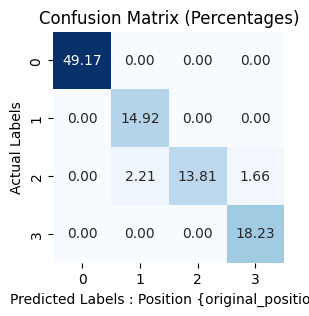

Confusion Matrix for Position -20.462534, -54.607062
[[79  0  0]
 [ 0 27  0]
 [ 0  0 75]]


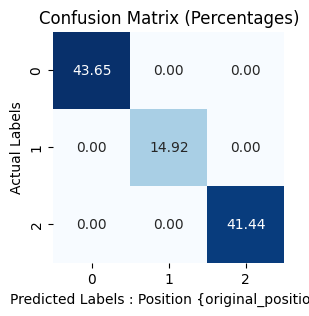

In [ ]:
# calculate and visualize the confusion matrix
""" A confusion matrix is a table used in machine learning to evaluate the
performance of a classification model, showing true positives, true negatives,
false positives, and false negatives."""

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred, label_name):
  # Generate a confusion matrix
  confusion = confusion_matrix(y_test, y_pred)
  print(confusion)

  # Calculate percentages for each cell in the confusion matrix
  total_samples = np.sum(confusion)
  confusion_percent = (confusion / total_samples) * 100

  # Plot the confusion matrix with percentages
  plt.figure(figsize=(4, 3))
  sns.heatmap(confusion_percent, annot=True, fmt='.2f', cmap='Blues', cbar=False, square=True)
  plt.xlabel('Predicted Labels : ' + label_name)
  plt.ylabel('Actual Labels')
  plt.title('Confusion Matrix (Percentages)')
  plt.show()

# Create a reverse mapping to get the original position from the integer
reverse_positions = {v: k for k, v in unique_positions.items()}

# Iterate over each position in the models dictionary
for pos, model_data in models.items():
    # Retrieve y_test and y_pred for the current position
    y_test_pos = model_data['y_test']
    y_pred_pos = model_data['y_pred']
    # Get the original position name using the reverse mapping
    original_position = reverse_positions[pos]
    # Plot the confusion matrix
    print(f"Confusion Matrix for Position {original_position}")
    plot_confusion_matrix(y_test_pos, y_pred_pos, "Position {original_position}")

In [ ]:
# Dictionary
data = {
    "position": [1],
    "time": [1561],
    "day": [4]
}

# DataFrame
new_df = pd.DataFrame(data)

print (model_pos.predict(new_df))


[0]


### **Download or Deploy Model**

In [ ]:
import joblib
from google.colab import files

# Create a reverse mapping to get the original position from the integer
reverse_positions = {v: k for k, v in unique_positions.items()}

# Iterate over each model in the models dictionary
for pos, model_data in models.items():
    # Retrieve the trained model for the current position
    model_pos = model_data['model']
    print (model_pos)

    # Get the original position name using the reverse mapping
    original_position = reverse_positions[pos]

    # Define a filename based on the original position identifier
    filename = f"{original_position}_model.joblib"

    # Export the model using joblib
    joblib.dump(model_pos, filename)

    # Download the model file
    files.download(filename)

    # Print the position and confirmation message
    print(f"Model for position '{original_position}' has been exported and downloaded as {filename}.")


RandomForestClassifier(class_weight={0: 10, 1: 27, 2: 4, 3: 40}, max_depth=8,
                       oob_score=True, random_state=90)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model for position '-20.496654, -54.650237' has been exported and downloaded as -20.496654, -54.650237_model.joblib.
RandomForestClassifier(class_weight={0: 10, 1: 27, 2: 4, 3: 40}, max_depth=8,
                       oob_score=True, random_state=90)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model for position '-20.462534, -54.607062' has been exported and downloaded as -20.462534, -54.607062_model.joblib.


In [ ]:
#from google.colab import drive
#drive.mount('/gdrive')

afonso_pena_model = joblib.load("/gdrive/My Drive/tmp/afonso_model.joblib")


# Dictionary
data = {
    "position": [1],
    "time": [1561],
    "day": [4]
}
#data = [1,1561,4]
# DataFrame
afonso_pena_df = pd.DataFrame(data)
afonso_pena_predict = afonso_pena_model.predict(afonso_pena_df).tolist()

print (afonso_pena_predict)


[0]


In [ ]:
print(sklearn.__version__)

NameError: name 'sklearn' is not defined